
A minimal runnable script that:
  * loads/creates placeholder organoid graphs,
  * builds the dataset,
  * trains with the two-phase sparse procedure,
  * prints evaluation metrics and top coefficients,
  * saves history to disk for later plotting.


In [47]:
import numpy as np

from datastructures import *
from training import *
from models import *
from residuals import *

In [48]:
# Load all organoids
data_dir = "training_data"
graphs = load_dir_to_graphs(data_dir)
print(f"Loaded {len(graphs)} organoids.")

# Load metadata & attach
meta = load_aux_metadata_for_dir("training_data")
attached = attach_metadata_to_graphs(graphs, meta)
print(f"Attached metadata to {attached}/{len(graphs)} graphs.")

Loaded 999 graphs; skipped 0.
Loaded 999 organoids.
Attached metadata to 999/999 graphs.


In [49]:

# (Optional) global outlier filtering BEFORE split (applies to all)
low_pct, high_pct = 0.0, 100.0   # example: keep middle 0–95th percentile
graphs, thr = filter_outliers(graphs, low_pct=low_pct, high_pct=high_pct, stat="median")
print(f"After global filter: {len(graphs)} organoids | thresholds: {thr}")

After global filter: 999 organoids | thresholds: {'low': -0.41922950744628906, 'high': 0.5147268772125244}


In [50]:
# graphs: list[Data] already loaded and with .meta attached
complexities = []
for g in graphs:
    md = getattr(g, "meta", {}) or {}
    v = md.get("complexity", np.nan)
    try:
        v = float(v)
    except Exception:
        v = np.nan
    complexities.append(v)

complexities = np.asarray(complexities, dtype=float)
mask_keep = np.isfinite(complexities) & (complexities >= 1.0)

kept_graphs    = [g for g, m in zip(graphs, mask_keep) if m]
dropped_graphs = [g for g, m in zip(graphs, mask_keep) if not m]

print(f"Complexity filter: kept {len(kept_graphs)} / {len(graphs)} | "
      f"dropped {len(dropped_graphs)} (missing/NaN or < 1)")

# replace your working list
graphs = kept_graphs

Complexity filter: kept 541 / 999 | dropped 458 (missing/NaN or < 1)


In [51]:
# Split dataset by organoid
g_train, g_val = split_graphs(graphs, val_frac=0.2, seed=None)
print(f"Split -> train: {len(g_train)} | val: {len(g_val)}")

Split -> train: 433 | val: 108


In [52]:

# for g in g_train: add_two_hop_edges_inplace(g, include_self_loops=False, keep_one_hop=True)
# for g in g_val:   add_two_hop_edges_inplace(g, include_self_loops=False, keep_one_hop=True)


In [53]:

# Build the model
n_markers = int(g_train[0].x.size(1))
model = PureSAGECurvature(
    n_markers=n_markers,
    hidden_dim=128,
    num_layers=4,
    dropout=0.1,      # ← important for LBFGS
    residual=True,
    norm='layer'      # ← LayerNorm plays nicely with eval closures
)

cfg = TrainConfig(
    lr=5e-4,          # not used by LBFGS; keep for consistency/logging
    batch_size=8,
    max_epochs=200,   # not used by LBFGS; we use outer_steps instead
    patience=200,
    huber_delta=1.0,
    lambda_calib=0.2,     # try 0.05–0.5
    calib_mode="corr"     # or "cov"
)


In [54]:

model, metrics, history = train(model, g_train, g_val, cfg)

# # from training import train_lbfgs
# # model, metrics, history = train_lbfgs(
# #     model, g_train, g_val, cfg,
# #     outer_steps=50,   # try 30–80
# #     lr=0.5,           # try 0.2–1.0
# #     max_iter=20,      # internal line-search iterations
# #     history_size=100
# # )
# print("Best val MAE:", metrics["val_mae"])


epoch 001 | train loss 0.1996 mae 0.4714 | val loss 0.0959 mae 0.1619
epoch 002 | train loss 0.0934 mae 0.2930 | val loss 0.0849 mae 0.2208
epoch 003 | train loss 0.0833 mae 0.2674 | val loss 0.0679 mae 0.1587
epoch 004 | train loss 0.0725 mae 0.2470 | val loss 0.0611 mae 0.1780
epoch 005 | train loss 0.0701 mae 0.2368 | val loss 0.0575 mae 0.1923
epoch 006 | train loss 0.0674 mae 0.2316 | val loss 0.0546 mae 0.2004
epoch 007 | train loss 0.0659 mae 0.2290 | val loss 0.0540 mae 0.1748
epoch 008 | train loss 0.0653 mae 0.2239 | val loss 0.0517 mae 0.2091
epoch 009 | train loss 0.0636 mae 0.2242 | val loss 0.0504 mae 0.1867
epoch 010 | train loss 0.0630 mae 0.2199 | val loss 0.0513 mae 0.2046
epoch 011 | train loss 0.0601 mae 0.2173 | val loss 0.0510 mae 0.1973
epoch 012 | train loss 0.0594 mae 0.2097 | val loss 0.0493 mae 0.1836
epoch 013 | train loss 0.0591 mae 0.2117 | val loss 0.0495 mae 0.2132
epoch 014 | train loss 0.0591 mae 0.2137 | val loss 0.0511 mae 0.2016
epoch 015 | train lo

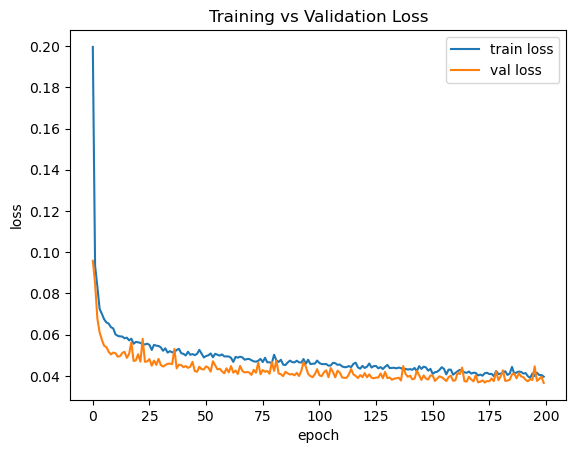

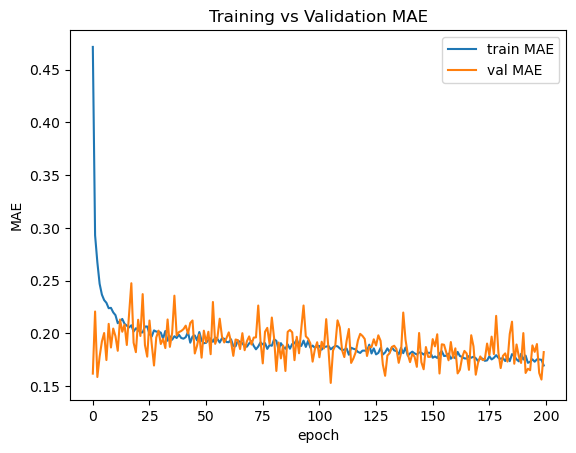

In [55]:
import json, os
import matplotlib.pyplot as plt

def _load_history_fallback():
    path = "artifacts/history.json"
    if os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)
    return None

# Use in-memory 'history' if present; else load from disk
try:
    _hist = history
except NameError:
    _hist = _load_history_fallback()

if _hist is None:
    print("No history found. Define a `history` dict or save it to artifacts/history.json.")
else:
    # Loss
    plt.figure()
    plt.plot(_hist.get("train_loss", []), label="train loss")
    plt.plot(_hist.get("val_loss", []), label="val loss")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Training vs Validation Loss")
    plt.legend(); plt.show()

    # MAE
    plt.figure()
    plt.plot(_hist.get("train_mae", []), label="train MAE")
    plt.plot(_hist.get("val_mae", []), label="val MAE")
    plt.xlabel("epoch"); plt.ylabel("MAE"); plt.title("Training vs Validation MAE")
    plt.legend(); plt.show()


In [57]:
import matplotlib.pyplot as plt
from analysis_basic import *

device = cfg.device if 'cfg' in globals() else ('cuda' if torch.cuda.is_available() else 'cpu')
marker_names = load_marker_names_from_dir(data_dir)

# === Inference on VALIDATION ===
y, yhat, X = run_inference(g_val, model, device=device)

# Residuals per marker (positives only)
residuals_model, residuals_base, n_pos, mu_pos = residuals_per_marker(y, yhat, X)


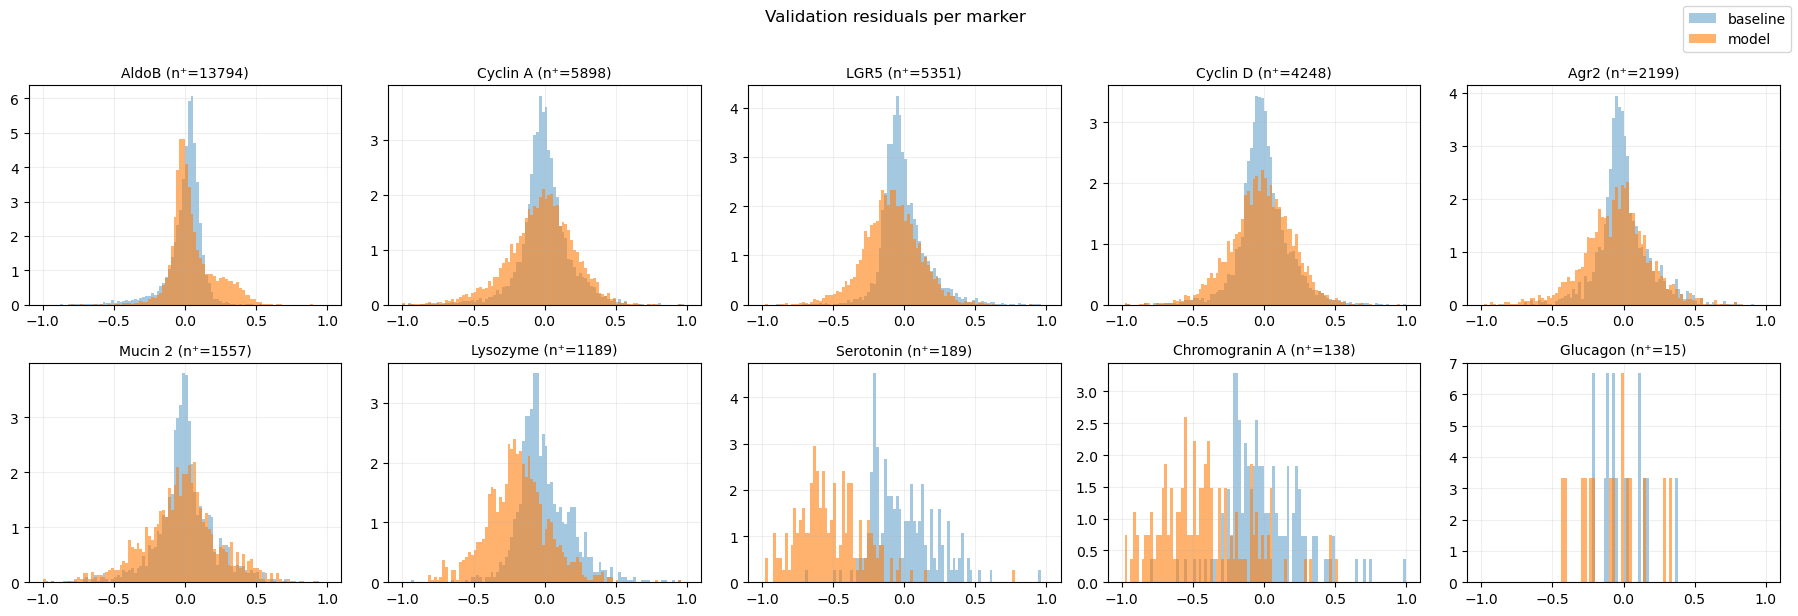

In [58]:
# Helper: pick top markers by positives for display
order_by_n = np.argsort(-n_pos)
marker_idx_show = order_by_n[:min(12, (X.shape[1] if X.ndim == 2 else 12))]
marker_names_sel = [marker_names[m] if m < len(marker_names) else f"m{m}" for m in marker_idx_show]

# === Histograms of residuals per marker (model vs baseline) ===
cols = 5; rows = int(np.ceil(len(marker_idx_show)/cols)) if len(marker_idx_show) else 1
fig, axes = plt.subplots(rows, cols, figsize=(cols*3.6, rows*3.0), squeeze=False)
axes = axes.ravel()
edges = np.linspace(-1.0, 1.0, 101)  # symmetric bins

for k, m in enumerate(marker_idx_show):
    ax = axes[k]
    rb = residuals_base[m]; rm = residuals_model[m]
    if rb.size == 0:
        ax.axis('off'); continue
    ax.hist(rb, bins=edges, density=True, alpha=0.4, label="baseline")
    ax.hist(rm, bins=edges, density=True, alpha=0.6, label="model")
    ax.set_title(f"{marker_names_sel[k]} (n⁺={n_pos[m]})", fontsize=10)
    ax.grid(True, alpha=0.2)

for k in range(len(marker_idx_show), len(axes)):
    axes[k].axis('off')
if len(marker_idx_show):
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")
fig.suptitle("Validation residuals per marker", y=1.02)
plt.tight_layout(); plt.show()


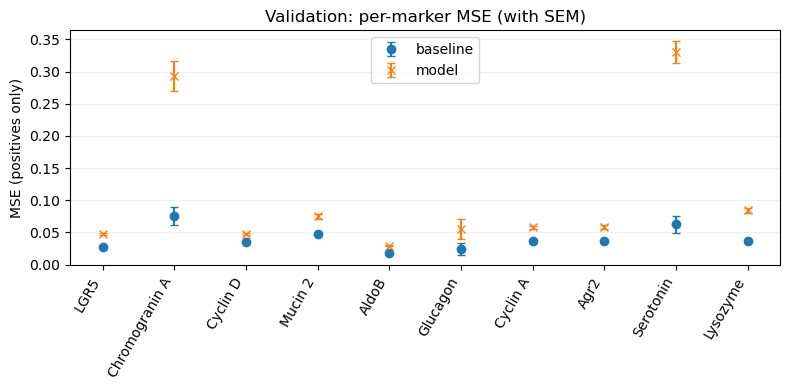

In [59]:
# MSE and SEM (SEM over squared residuals)
mse_model = np.array([np.mean(r**2) for r in residuals_model])
mse_base  = np.array([np.mean(r**2) for r in residuals_base])
sem_model = np.array([np.std((r**2), ddof=1)/np.sqrt(r.size) for r in residuals_model])
sem_base  = np.array([np.std((r**2), ddof=1)/np.sqrt(r.size) for r in residuals_base])

x = np.arange(len(marker_names))

plt.figure(figsize=(max(8, 0.5*len(marker_names)), 4))
plt.errorbar(x, mse_base,  yerr=sem_base,  fmt='o', capsize=3, label="baseline")
plt.errorbar(x, mse_model, yerr=sem_model, fmt='x', capsize=3, label="model")
plt.xticks(x, marker_names, rotation=60, ha='right')
plt.ylabel("MSE (positives only)")
plt.title("Validation: per-marker MSE (with SEM)")
plt.grid(True, axis='y', alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()


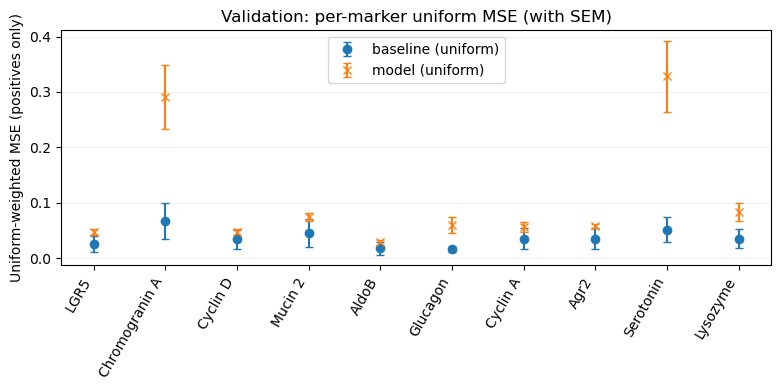

In [60]:
# ===  Uniformly weighted MSE per marker (model and baseline) ===
# Build y/pred lists per marker once (positives only)
# Build per-marker slices (positives only)
y_list     = [y[X[:, m] > 0.5] for m in range(X.shape[1])]
yhat_list  = [yhat[X[:, m] > 0.5] for m in range(X.shape[1])]
ybase_list = [np.full_like(y_list[m], mu_pos[m]) for m in range(X.shape[1])]

uw_model, se_model = uniform_weighted_mse(y_list, yhat_list, nbins=8, strategy="quantile")
uw_base,  se_base  = uniform_weighted_mse(y_list, ybase_list, nbins=8, strategy="quantile")

x = np.arange(len(marker_names))
plt.figure(figsize=(max(8, 0.5*len(marker_names)), 4))
plt.errorbar(x, uw_base,  yerr=se_base,  fmt='o', capsize=3, label="baseline (uniform)")
plt.errorbar(x, uw_model, yerr=se_model, fmt='x', capsize=3, label="model (uniform)")
plt.xticks(x, marker_names, rotation=60, ha='right')
plt.ylabel("Uniform-weighted MSE (positives only)")
plt.title("Validation: per-marker uniform MSE (with SEM)")
plt.grid(True, axis='y', alpha=0.2)
plt.legend(); plt.tight_layout(); plt.show()



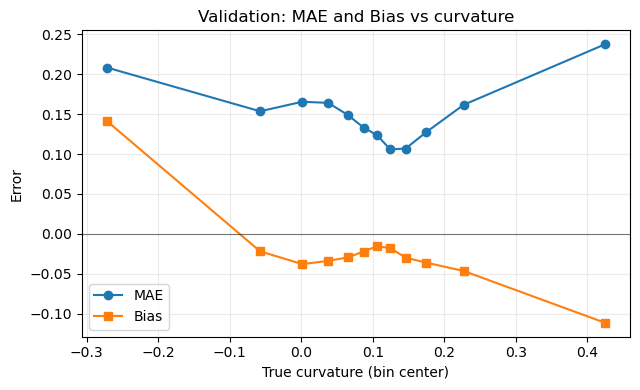

In [61]:
# === total MAE + bias vs (binned) curvature (global) ===
edges_glob, centers_glob = build_bins_from_true(y, nbins=12, strategy="quantile")

counts_glob, mae_glob, _, _ = bin_by_curvature(y, np.abs(yhat - y), edges=edges_glob, strategy="quantile")
_, bias_glob, _, _ = bin_by_curvature(y, (yhat - y), edges=edges_glob, strategy="quantile")

plt.figure(figsize=(6.5, 4))
plt.plot(centers_glob, mae_glob,  'o-', label="MAE")
plt.plot(centers_glob, bias_glob, 's-', label="Bias")
plt.axhline(0.0, color='k', lw=0.8, alpha=0.5)
plt.xlabel("True curvature (bin center)")
plt.ylabel("Error")
plt.title("Validation: MAE and Bias vs curvature")
plt.grid(True, alpha=0.25)
plt.legend(); plt.tight_layout(); plt.show()


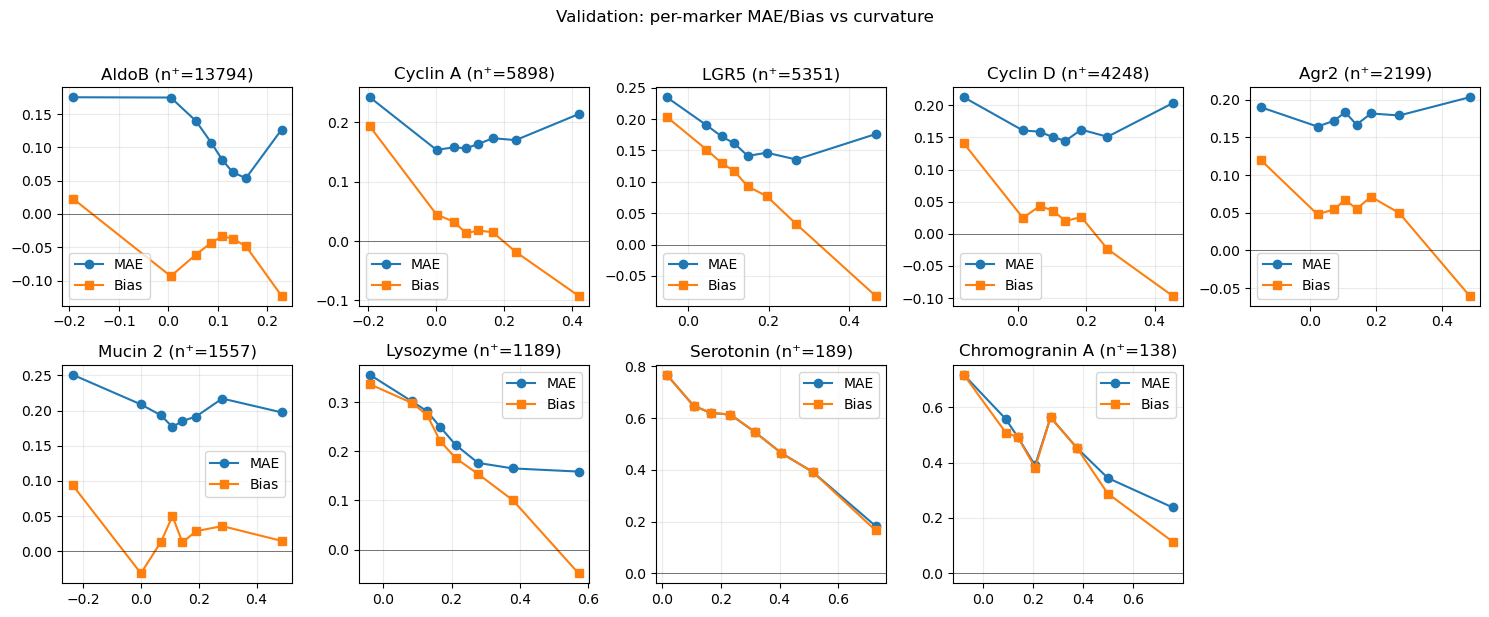

In [62]:
# === MAE + bias per marker vs (binned) curvature ===
# Build per-marker lists (positives only)
abs_res_list = [np.abs(yhat[X[:, m] > 0.5] - y[X[:, m] > 0.5]) for m in range(X.shape[1])]
res_list     = [      yhat[X[:, m] > 0.5] - y[X[:, m] > 0.5]   for m in range(X.shape[1])]
y_pos_list   = [y[X[:, m] > 0.5] for m in range(X.shape[1])]

# Bin each series by its own curvature distribution (quantile bins)
cnt_mae_list,  mae_list,  _, centers_mae_list  = bin_by_curvature(
    y_pos_list, abs_res_list, edges=None, nbins=8, strategy="quantile"
)
cnt_bias_list, bias_list, _, centers_bias_list = bin_by_curvature(
    y_pos_list, res_list,     edges=None, nbins=8, strategy="quantile"
)

max_markers = 12
order_by_n  = np.argsort(-n_pos)
selm        = [m for m in order_by_n if len(y_pos_list[m]) >= 30][:max_markers]

cols = 5
rows = int(np.ceil(len(selm)/cols)) if len(selm) else 1
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3), squeeze=False)
axes = axes.ravel()

for k, m in enumerate(selm):
    ax = axes[k]
    centers_m = centers_mae_list[m]  # same binning for abs_res and res (both from quantile on y_pos_list[m])
    ax.plot(centers_m, mae_list[m],  'o-', label="MAE")
    ax.plot(centers_m, bias_list[m], 's-', label="Bias")
    ax.axhline(0.0, color='k', lw=0.7, alpha=0.5)
    ax.set_title(f"{marker_names[m] if m < len(marker_names) else f'm{m}'} (n⁺={n_pos[m]})")
    ax.grid(True, alpha=0.25)
    ax.legend()

for k in range(len(selm), len(axes)):
    axes[k].axis('off')

fig.suptitle("Validation: per-marker MAE/Bias vs curvature", y=1.02)
plt.tight_layout(); plt.show()


In [66]:
from graph_audit import audit_dataset, ablation_edges_and_shuffle

# Quick sample audit (prints warnings inline)
_ = audit_dataset(g_train, sample_k=5, marker_names=marker_names, seed=0)

# Global ablation sanity on the whole train set
abl = ablation_edges_and_shuffle(model, g_train, device=cfg.device, batch_size=8)
print("\nAblations on TRAIN:")
for k, v in abl.items():
    print(f"  {k:>10s} -> MAE={v['MAE']:.4f}  MSE={v['MSE']:.6f}")

# (optional) also run on validation
abl_val = ablation_edges_and_shuffle(model, g_val, device=cfg.device, batch_size=8)
print("\nAblations on VAL:")
for k, v in abl_val.items():
    print(f"  {k:>10s} -> MAE={v['MAE']:.4f}  MSE={v['MSE']:.6f}")



=== Graph #273 ===
[Graph audit]
- nodes=374 edges=2242 | out_of_range=0 self_loops=0 dup_dir=2242 undirected_symmetry=1.000
- deg0_frac=0.000 deg_mean=5.99 p90=8.0 max=10
- components=1 (small<=5: 0) largest=374
- two_hop_cover_frac≈0.055 | Moran-I(y)≈0.727
- homophily same_frac(mean across markers)≈0.912

=== Graph #220 ===
[Graph audit]
- nodes=727 edges=4372 | out_of_range=0 self_loops=0 dup_dir=4372 undirected_symmetry=1.000
- deg0_frac=0.000 deg_mean=6.01 p90=8.0 max=11
- components=1 (small<=5: 0) largest=727
- two_hop_cover_frac≈0.028 | Moran-I(y)≈0.728
- homophily same_frac(mean across markers)≈0.972

=== Graph #116 ===
[Graph audit]
- nodes=361 edges=2160 | out_of_range=0 self_loops=0 dup_dir=2160 undirected_symmetry=1.000
- deg0_frac=0.000 deg_mean=5.98 p90=8.0 max=10
- components=1 (small<=5: 0) largest=361
- two_hop_cover_frac≈0.056 | Moran-I(y)≈0.656
- homophily same_frac(mean across markers)≈0.901

=== Graph #133 ===
[Graph audit]
- nodes=307 edges=1834 | out_of_range=0